### 0. 事前準備

以下のデータを取得して、このノートブックと同じディレクトリにある`data`ディレクトリに配置します。

__COVID-19 World Vaccination Progress__  
URL:  
・https://www.kaggle.com/gpreda/covid-world-vaccination-progress    
DATA:  
・country_vaccinations.csv  
・country_vaccinations_by_manufacturer.csv

---

__Annotated geo-json geometry files for the world__  
URL:  
・https://github.com/johan/world.geo.json  
DATA:  
・countries.geo.json

In [1]:
%matplotlib inline

import folium
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

### 1. データの概要を把握
まずデータの概要を掴んでみましょう。

国別ワクチン接種状況データをロード。

In [2]:
country_vaccinations_df = pd.read_csv('data/country_vaccinations.csv')

len(country_vaccinations_df)

72312

データの中身を確認。  
不明な属性があれば、データ取得元で確認します。

In [3]:
country_vaccinations_df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


`info()`で列の情報を取得します。

以下はどんな属性でしょうか？  
- `people_fully_vaccinated`
- `daily_vaccinations_raw`
- `daily_vaccinations`
- `people_vaccinated_per_hundred`

In [4]:
country_vaccinations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              72312 non-null  object 
 1   iso_code                             72312 non-null  object 
 2   date                                 72312 non-null  object 
 3   total_vaccinations                   37946 non-null  float64
 4   people_vaccinated                    36005 non-null  float64
 5   people_fully_vaccinated              33249 non-null  float64
 6   daily_vaccinations_raw               31028 non-null  float64
 7   daily_vaccinations                   71946 non-null  float64
 8   total_vaccinations_per_hundred       37946 non-null  float64
 9   people_vaccinated_per_hundred        36005 non-null  float64
 10  people_fully_vaccinated_per_hundred  33249 non-null  float64
 11  daily_vaccinations_per_milli

`source_name`、`source_website`列は今回必要ないので削除します。

In [5]:
country_vaccinations_df.drop(columns={'source_name', 'source_website'}, inplace=True)

country_vaccinations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              72312 non-null  object 
 1   iso_code                             72312 non-null  object 
 2   date                                 72312 non-null  object 
 3   total_vaccinations                   37946 non-null  float64
 4   people_vaccinated                    36005 non-null  float64
 5   people_fully_vaccinated              33249 non-null  float64
 6   daily_vaccinations_raw               31028 non-null  float64
 7   daily_vaccinations                   71946 non-null  float64
 8   total_vaccinations_per_hundred       37946 non-null  float64
 9   people_vaccinated_per_hundred        36005 non-null  float64
 10  people_fully_vaccinated_per_hundred  33249 non-null  float64
 11  daily_vaccinations_per_milli

数値属性の集計情報を確認。  
どんな特徴が読み取れますか？

In [6]:
country_vaccinations_df.describe()

,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,3.794600e+04,3.600500e+04,3.324900e+04,3.102800e+04,7.194600e+04,37946.000000,36005.000000,33249.000000,71946.000000
mean,3.716389e+07,1.474947e+07,1.086615e+07,2.779412e+05,1.380304e+05,68.334834,37.015007,31.026356,3469.935132
std,1.887931e+08,5.883567e+07,4.488201e+07,1.260971e+06,8.170834e+05,60.242876,28.326786,27.089799,4106.454043
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,4.338678e+05,2.952590e+05,1.882380e+05,5.350000e+03,9.820000e+02,11.740000,8.800000,4.820000,681.000000
50%,2.862344e+06,1.822343e+06,1.265305e+06,2.661150e+04,7.947000e+03,54.070000,34.730000,24.660000,2275.000000
75%,1.360792e+07,7.255645e+06,5.786627e+06,1.273820e+05,4.552475e+04,116.880000,63.250000,55.840000,5050.000000
max,2.968121e+09,1.265034e+09,1.224450e+09,2.474100e+07,2.242429e+07,327.790000,122.690000,120.700000,117497.000000


データフレームの`hist()`を使ってヒストグラムを表示します。

どんなことが読み取れますか？  
「1e9」は10の9乗の意味です。

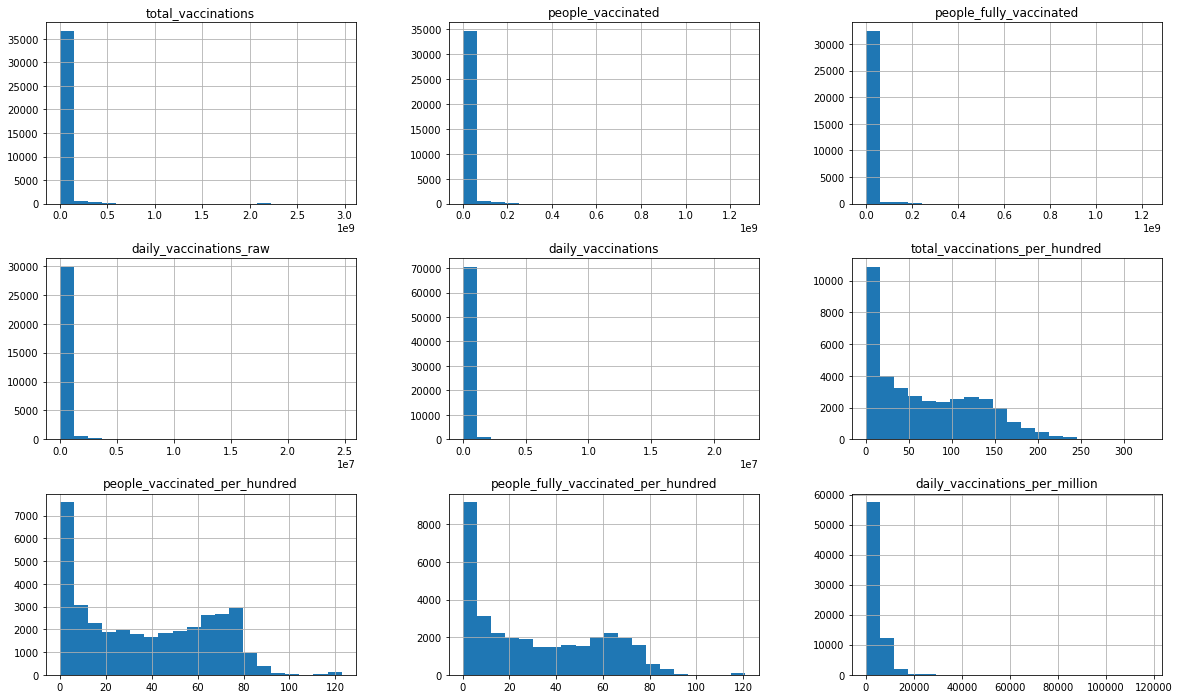

In [7]:
country_vaccinations_df.hist(bins=20, figsize=(20, 12)); # セミコロンでテキスト出力を除去

`daily_vaccinations_raw`と`daily_vaccinations`のグラフがかなり異なります。  
かなりの欠損値がありそうです。

もう一度`info()`で列ごとの欠損値を確認してみます。

In [8]:
country_vaccinations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              72312 non-null  object 
 1   iso_code                             72312 non-null  object 
 2   date                                 72312 non-null  object 
 3   total_vaccinations                   37946 non-null  float64
 4   people_vaccinated                    36005 non-null  float64
 5   people_fully_vaccinated              33249 non-null  float64
 6   daily_vaccinations_raw               31028 non-null  float64
 7   daily_vaccinations                   71946 non-null  float64
 8   total_vaccinations_per_hundred       37946 non-null  float64
 9   people_vaccinated_per_hundred        36005 non-null  float64
 10  people_fully_vaccinated_per_hundred  33249 non-null  float64
 11  daily_vaccinations_per_milli

### 2. 地図を使ってデータを把握

ここでは、各国をワクチン２回接種の割合で色分けしてみます。

各国ごとの最新のワクチン２回接種割合のデータフレームを作成。

In [9]:
country_fully_vaccinated_df = country_vaccinations_df.groupby(['country', 'iso_code'])\
                                .max()['people_fully_vaccinated_per_hundred'].reset_index()

country_fully_vaccinated_df.head(20)

,country,iso_code,people_fully_vaccinated_per_hundred
0,Afghanistan,AFG,9.63
1,Albania,ALB,38.66
2,Algeria,DZA,12.99
3,Andorra,AND,66.44
4,Angola,AGO,12.70
5,Anguilla,AIA,61.61
6,Antigua and Barbuda,ATG,60.24
7,Argentina,ARG,75.07
8,Armenia,ARM,26.44
9,Aruba,ABW,74.29


棒グラフで分布を確認。

`sns.barplot()`でグラフを描画します。

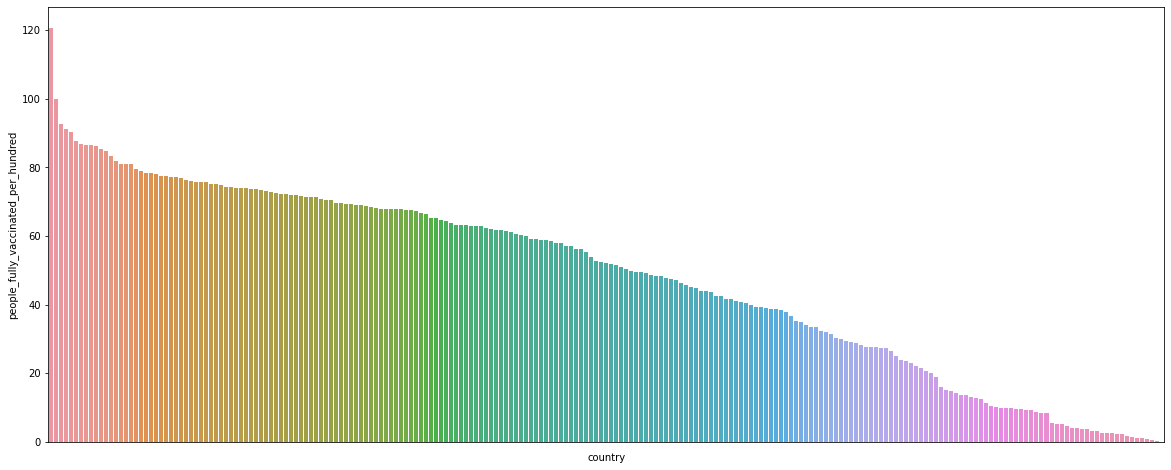

In [10]:
fig, ax = plt.subplots(figsize=(20,8))

country_fully_vaccinated_from_top_df = \
    country_fully_vaccinated_df.sort_values('people_fully_vaccinated_per_hundred', ascending=False)
sns.barplot(
    x=country_fully_vaccinated_from_top_df['country'],
    y=country_fully_vaccinated_from_top_df['people_fully_vaccinated_per_hundred'])

# x軸目盛りとラベルを表示しない。
ax.set(xticklabels=[])
ax.tick_params(bottom=False)

`folium.Choropleth()`でコロプレスマップを描画します。  
国ごとの区画情報は`countries.geo.json`を利用します。

どんなことが読み取れますか？

In [11]:
map = folium.Map(location=[0,0], zoom_start=2.4)

folium.Choropleth(
    geo_data='data/countries.geo.json',
    data=country_fully_vaccinated_df,
    fill_opacity=1,
    line_color='black',
    nan_fill_color='#888888',
    columns=['iso_code', 'people_fully_vaccinated_per_hundred'],
    key_on= "feature.id",
    fill_color='RdBu').add_to(map)

map

### 3. 少しだけ掘り下げた分析をしてみる

各製造メーカー製ワクチン別の接種状況がどのように推移しているかを分析してみます。

製造メーカー別のワクチン接種データをロード。

In [12]:
country_vaccinations_by_manufacturer_df = pd.read_csv('data/country_vaccinations_by_manufacturer.csv')

len(country_vaccinations_by_manufacturer_df)

26031

データの中身を確認。

In [13]:
country_vaccinations_by_manufacturer_df.head(10)

,location,date,vaccine,total_vaccinations
0,Austria,2021-01-08,Johnson&Johnson,0
1,Austria,2021-01-08,Moderna,0
2,Austria,2021-01-08,Oxford/AstraZeneca,0
3,Austria,2021-01-08,Pfizer/BioNTech,31523
4,Austria,2021-01-15,Johnson&Johnson,0
5,Austria,2021-01-15,Moderna,94
6,Austria,2021-01-15,Oxford/AstraZeneca,0
7,Austria,2021-01-15,Pfizer/BioNTech,116861
8,Austria,2021-01-22,Johnson&Johnson,0
9,Austria,2021-01-22,Moderna,332


`info()`で各列の情報を確認。

不明な列はありますか？

また、欠損値はありますか？

In [14]:
country_vaccinations_by_manufacturer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26031 entries, 0 to 26030
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   location            26031 non-null  object
 1   date                26031 non-null  object
 2   vaccine             26031 non-null  object
 3   total_vaccinations  26031 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 813.6+ KB


どうも`total_vaccinations`は国・メーカー別の累計のようですが、念のため確認してみます。

In [15]:
### チャレンジしてみよう！！ ###

グラフのX軸目盛用に`month`列を追加。

In [16]:
country_vaccinations_by_manufacturer_df['month'] = pd.to_datetime(
    country_vaccinations_by_manufacturer_df.date, format='%Y-%m-%d').dt.strftime('%Y-%m')

country_vaccinations_by_manufacturer_df['month']

0        2021-01
1        2021-01
2        2021-01
3        2021-01
4        2021-01
          ...   
26026    2022-01
26027    2022-01
26028    2022-01
26029    2022-01
26030    2022-01
Name: month, Length: 26031, dtype: object

グラフを表示した時に各ワクチンが同じ色でされるよう、`vaccine`列をカテゴリ型に変換します。

In [17]:
country_vaccinations_by_manufacturer_df['vaccine'] = country_vaccinations_by_manufacturer_df['vaccine'] \
                                                     .astype('category')

country_vaccinations_by_manufacturer_df['vaccine']

0           Johnson&Johnson
1                   Moderna
2        Oxford/AstraZeneca
3           Pfizer/BioNTech
4           Johnson&Johnson
                ...        
26026    Oxford/AstraZeneca
26027       Pfizer/BioNTech
26028     Sinopharm/Beijing
26029               Sinovac
26030             Sputnik V
Name: vaccine, Length: 26031, dtype: category
Categories (8, object): ['CanSino', 'Johnson&Johnson', 'Moderna', 'Oxford/AstraZeneca', 'Pfizer/BioNTech', 'Sinopharm/Beijing', 'Sinovac', 'Sputnik V']

国、ワクチン、月別でグループ化し、接種回数を計算したデータフレームを生成。

`total_vaccinations`が累計という前提で、最大値を取得します。

In [18]:
location_vaccine_month_df = country_vaccinations_by_manufacturer_df \
                                     .groupby(['location', 'vaccine', 'month']) \
                                     .agg({'total_vaccinations': 'max'}) \
                                     .reset_index()

location_vaccine_month_df.head()

,location,vaccine,month,total_vaccinations
0,Austria,CanSino,2020-12,NaN
1,Austria,CanSino,2021-01,NaN
2,Austria,CanSino,2021-02,NaN
3,Austria,CanSino,2021-03,NaN
4,Austria,CanSino,2021-04,NaN


`total_vaccinations`列に`NaN`が含まれているようなので確認します。

In [19]:
print(f"total_vaccinationsのNaN数: {location_vaccine_month_df['total_vaccinations'].isna().sum()}")

total_vaccinationsのNaN数: 2594


`vaccine`列をカテゴリ型にしたため、`location`、`vaccine`、`month`のすべての組み合わせの行が作られ、存在しない組み合わせの場合は`total_vaccinations`列の値が`NaN`になっています。

これを`fillna()`で`0`で埋めます。

In [20]:
location_vaccine_month_df['total_vaccinations'].fillna(0, inplace=True)

print(f"total_vaccinationsのNaN数: {location_vaccine_month_df['total_vaccinations'].isna().sum()}")

total_vaccinationsのNaN数: 0


問題ないようであれば、今度は世界全体のデータを計算します。

ワクチン、月別でグループ化し、接種回数を計算したデータフレームを生成し、月でソートします。

今度は`total_vaccinations`の合計値を取得します。

In [21]:
world_vaccine_month_df = location_vaccine_month_df \
                          .groupby(['vaccine', 'month']) \
                          .agg({'total_vaccinations': 'sum'}) \
                          .reset_index() \
                          .sort_values('month')

world_vaccine_month_df.head()

,vaccine,month,total_vaccinations
0,CanSino,2020-12,0.0
56,Pfizer/BioNTech,2020-12,564686.0
28,Moderna,2020-12,79.0
70,Sinopharm/Beijing,2020-12,0.0
42,Oxford/AstraZeneca,2020-12,8.0


折れ線グラフを表示します。

どんなことが読み取れますか？

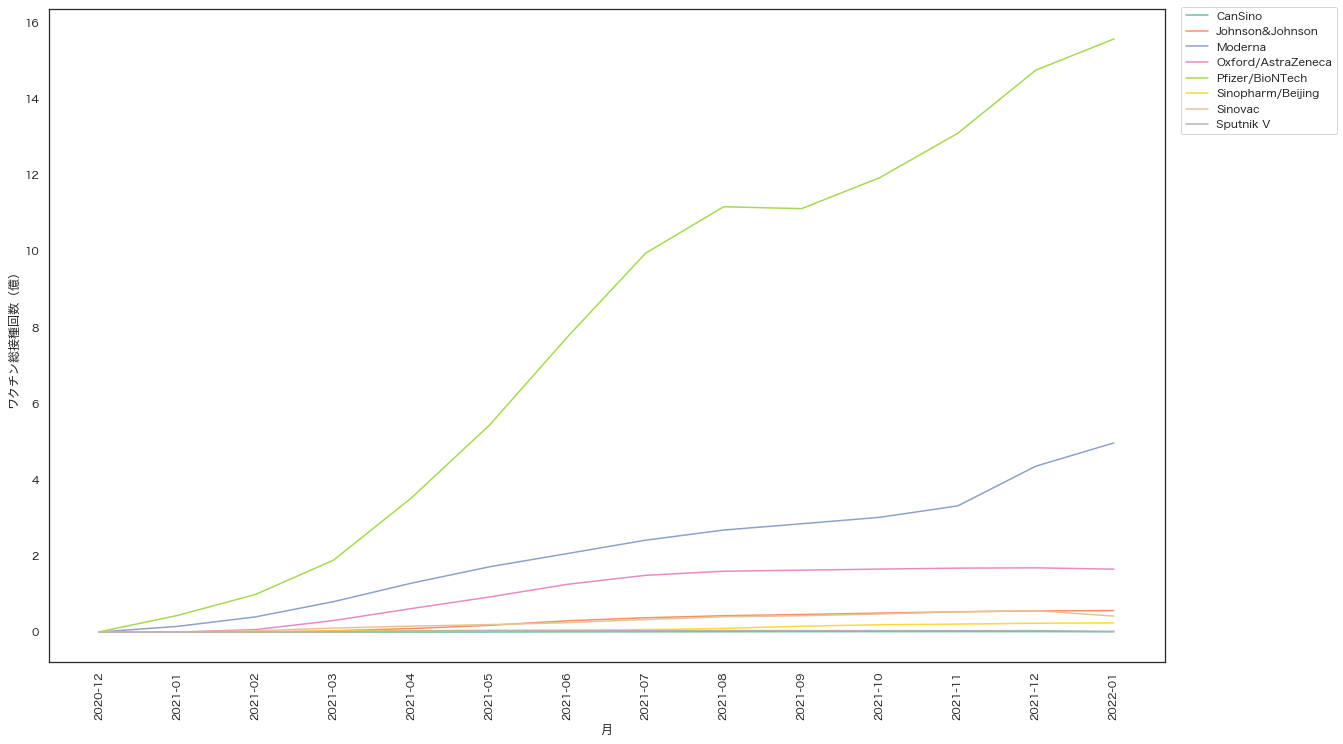

In [22]:
sns.set(palette='Set2', style='white', font=['MS Gothic','Hiragino Sans']) # 日本語フォントは設定が必要

fig, ax = plt.subplots(figsize=(20,12))

sns.lineplot(data=world_vaccine_month_df,
             x='month',
             y='total_vaccinations',
             hue='vaccine')

ax.set_xlabel("月");
plt.xticks(rotation=90)

ax.set_ylabel("ワクチン総接種回数（億）");
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/100_000_000))) # 億単位

ax.legend(loc="lower left", bbox_to_anchor=(1.01, 0.8))

同様に、任意の8ヵ国についてワクチン別の接種回数の推移をグラフで表示してみましょう。

In [25]:
random_countries = np.random.choice(location_vaccine_month_df['location'].unique(), 8)

random_countries.sort()

random_countries

array(['Chile', 'Ecuador', 'Germany', 'Lithuania', 'Netherlands', 'Peru',
       'Poland', 'Spain'], dtype=object)

折れ線グラフを2列ずつ表示します。

どんなことが読み取れますか？

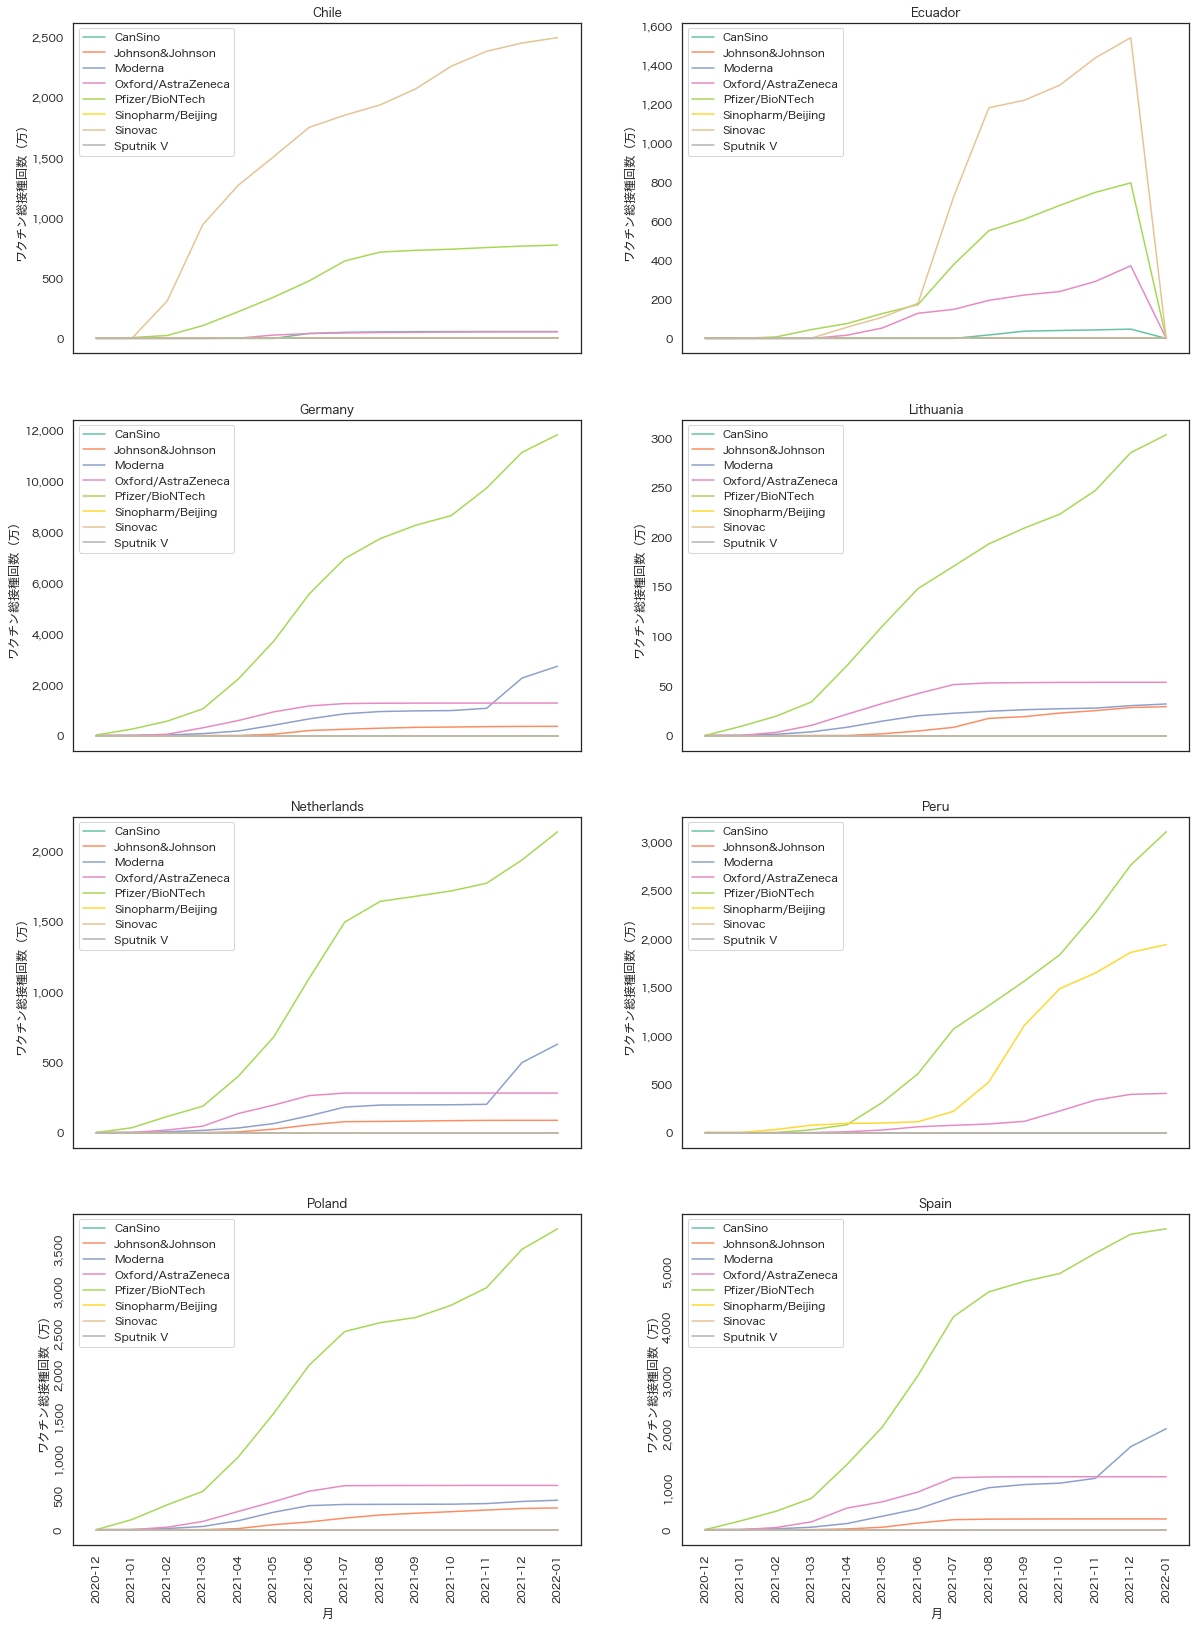

In [26]:
nrows = len(random_countries) // 2
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows*7), sharex=True)

for i in range(nrows):
    for j in range(ncols):
        target_ax = axes[i, j]
        target_country = random_countries[i*ncols + j]
        
        sns.lineplot(data=location_vaccine_month_df.query('location == @target_country').sort_values('month'),
                     x='month',
                     y='total_vaccinations',
                     hue='vaccine',
                     ax=target_ax)
        
        target_ax.set_title(target_country)
        
        target_ax.set_xlabel("月");
        
        target_ax.set_ylabel("ワクチン総接種回数（万）");
        target_ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y/10_000))); # 万単位
    
        target_ax.legend(loc="upper left")
    
axes[nrows-1,0].tick_params(labelrotation=90)
axes[nrows-1,1].tick_params(labelrotation=90)